# Introduction

This notebook presents **YOLOv2** applied to the [Blood Cell Images](https://www.kaggle.com/paultimothymooney/blood-cells) dataset.

**Resources**

* [BCCD Dataset](https://github.com/Shenggan/BCCD_Dataset) - alternative dataset source with links to original authors

# Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import PIL
import PIL.Image
import PIL.ImageDraw
import xml.etree.ElementTree as ET

Limit TensorFlow GPU memory usage

In [2]:
import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True)  # init TF ...
config=tf.ConfigProto(gpu_options=gpu_options)  # w/o taking ...
with tf.Session(config=config): pass            # all GPU memory

# Configuration

In [3]:
dataset_location = '/home/marcin/Datasets/blood-cells/dataset-master/'

In [4]:
anchors = ((0.57273, 0.677385),  # anchor-box nb 1, width & height, unit: cell_size
           (1.87446, 2.06253),   # anchor-box nb 2,
           (3.33843, 5.47434),   # ...
           (7.88282, 3.52778),
           (9.77052, 9.16828))

In [5]:
classes = ['RBC']

In [6]:
images_location = os.path.join(dataset_location, 'JPEGImages')
annotations_location = os.path.join(dataset_location, 'Annotations')

In [7]:
filename_list_xml = sorted(os.listdir(annotations_location))
display(filename_list_xml[:3])

['BloodImage_00000.xml', 'BloodImage_00001.xml', 'BloodImage_00002.xml']

In [8]:
class ImageWrapper:
    def __init__(self, filepath, width, height, depth):
        self.filepath = filepath
        self.width = width
        self.height = height
        self.depth = depth
        self.objects = []
    def __str__(self):
        return f'{self.filepath}\nw:{self.width} h:{self.height} d:{self.depth}'

In [9]:
class BBoxWrapper:
    def __init__(self, name, xmin ,ymin, xmax, ymax):
        self.name = name
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
    def __str__(self):
        return f'{self.name} {self.xmin} {self.ymin} {self.xmax} {self.ymax}'

In [10]:
image_wrapper_list = []

for filename_xml in filename_list_xml:       # 'BloodImage_00000.xml'
    filepath_xml = os.path.join(             # '/../../BloodImage_00000.xml'
        annotations_location, filename_xml)  
    tree = ET.parse(filepath_xml)            # xml.etree.ElementTree.ElementTree
    
    filename = tree.find('./filename').text  # 'BloodImage_00000'
    w = tree.find('./size/width').text       # '640'
    h = tree.find('./size/height').text      # '480'
    d = tree.find('./size/depth').text       # '3'
    
    filepath_jpg = os.path.join(             # '/../../BloodImage_00000.jpg'
        images_location, filename+'.jpg')
    
    assert os.path.isfile(filepath_jpg)
    
    iw = ImageWrapper(filepath=filepath_jpg, width=int(w),
                      height=int(h), depth=int(d))
    
    object_elemnts = tree.findall('./object')  # [xml.etree.ElementTree.ElementTree, ...]
    for obj_el in object_elemnts:
    
        name = obj_el.find('./name').text         # 'RBC'
        xmin = obj_el.find('./bndbox/xmin').text  # '233'
        ymin = obj_el.find('./bndbox/ymin').text  # '368'
        xmax = obj_el.find('./bndbox/xmax').text  # '338'
        ymax = obj_el.find('./bndbox/ymax').text  # '452'
        
        bbw = BBoxWrapper(name=name, xmin=int(xmin), ymin=int(ymin),
                           xmax=int(xmax), ymax=int(ymax))
        
        iw.objects.append(bbw)
        
    image_wrapper_list.append(iw)

In [11]:
for img_wrapper in image_wrapper_list:
    print(img_wrapper)
    for bbox_wrapper in img_wrapper.objects:
        print('  ', bbox_wrapper)
    break

/home/marcin/Datasets/blood-cells/dataset-master/JPEGImages/BloodImage_00000.jpg
w:640 h:480 d:3
   RBC 216 359 316 464
   RBC 77 326 177 431
   RBC 540 353 640 458
   RBC 405 350 513 457
   RBC 160 72 245 177
   RBC 5 335 90 440
   RBC 540 39 640 149
   RBC 383 1 504 113
   RBC 9 82 108 168
   RBC 68 212 165 346
   RBC 171 181 264 282


**Data Loader**

In [12]:
class BloodSequence(tf.keras.utils.Sequence):
    def __init__(self, image_wrapper_list, target_size, number_cells,
                 anchors, class_names, batch_size,
                 preprocess_images_function=None,
                 #preprocess_keypts_function=None,
                 shuffle=False):
        assert isinstance(image_wrapper_list, (list, tuple, np.ndarray))
        assert isinstance(target_size, int) and target_size > 0
        assert isinstance(number_cells, int) and number_cells > 0
        assert isinstance(anchors, (tuple, list))
        assert isinstance(anchors[0], (tuple, list)) and len(anchors[0]) == 2  # 2 = w,h
        assert isinstance(class_names, (tuple, list))
        assert isinstance(class_names[0], str)
        assert isinstance(batch_size, int) and batch_size > 0
        assert preprocess_images_function is None or callable(preprocess_images_function)
        #assert preprocess_keypts_function is None or callable(preprocess_keypts_function)
        assert isinstance(shuffle, bool)
        
        if target_size / number_cells != 32:
            raise ValueError(
                'target_size and number_cells must be such that cell width is 32')
        self.cell_width = 32
        self.cell_height = 32
    
        self.image_wrapper_list = np.array(image_wrapper_list)  # for advanced indexing
        self.target_size = target_size        # int, e.g. 416
        self.number_cells = number_cells      # int, e.g. 13
        self.anchors = anchors                # [[anchor_1_w, anchor_1_h], ...]
        self.class_names = class_names        # ['RBC', ...]
        self.batch_size = batch_size
        self.preprocess_images_function = preprocess_images_function
        #self.preprocess_keypts_function = preprocess_keypts_function
        self.shuffle = shuffle
        self.on_epoch_end()
    
    
    def __len__(self):
        return int(np.ceil(len(self.image_wrapper_list) / self.batch_size))
    
    
    def __getitem__(self, idx):
        """
        Images format:
         - type: np.ndarray, dtype float
         - shape: (batch_size, target_size, target_size, 3)
        Targets format:
         - type: np.ndarray, dtype float
         - shape: (batch_size, nb_cells, nb_cells, nb_anchors, 5 + nb_classes)
         - where last dim is arranged as follows:
             [bbox_center_x, bbox_center_y, bbox_width, bbox_height, confidence, classes]
           + bbox_ params are expressed in cell_width/height as a unit
           + confidence is "objectness" from the paper
           + classes is a one-hot encoded object class
           + e.g. [1.5, 2.5, 2, 3, 1, 0, 0, 1]
                                      ^--^--^-- class
                                   ^----------- object present (if zero ignore other vals)    
                                ^------ bbox is 3x cells wide (32*3=96 pixels)
                             ^----- bbox is 2x cells tall
                          ^---- bbox center is in the 3rd row of cell grid
                    ^--- bbox center is in 2nd column of cell grid
         
         
        Returns:
            (images, targets): two np.ndarray with training mini-batch
        """
        
        # TOOD: change xywh unit to cell + 0..1
        
        batch_i = self.indices[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_iw = self.image_wrapper_list[batch_i]    # [ImageWrapper, ...]
        
        images_shape = (
            len(batch_iw),      # batch size
            self.target_size,   # width, e.g 416
            self.target_size,   # height, e.g. 416
            3,                  # nb channels, RGB
        )
        
        targets_shape = (
            len(batch_iw),                  # batch size
            self.number_cells,              # nb cells x, 13
            self.number_cells,              # nb cells y, 13
            len(self.anchors),              # nb anchors
            4 + 1 + len(self.class_names))  # x,y,w,h, conf, clases
        
        images_arr = np.zeros(shape=images_shape, dtype=np.uint8)
        targets_arr = np.zeros(shape=targets_shape, dtype=float)
        
        
        for i, img_wrapper in enumerate(batch_iw):

            #
            #   Load Image
            #
            image = PIL.Image.open(img_wrapper.filepath)
            image_w, image_h = image.size
            image_new = image.resize((self.target_size, self.target_size),
                                     resample=PIL.Image.LANCZOS)
            images_arr[i] = np.array(image_new)
            
            #
            #   Load Objects
            #
            for obj_wrapper in img_wrapper.objects:
                
                if obj_wrapper.name not in self.class_names:
                    continue
                
                xmin, ymin = obj_wrapper.xmin, obj_wrapper.ymin  # unit: input img pixels
                xmax, ymax = obj_wrapper.xmax, obj_wrapper.ymax
                
                center_x_px = (xmin + xmax) / 2    # bounding box center
                center_y_px = (ymin + ymax) / 2    # unit: input img pixels, [0..image_h]
                size_w_px = (xmax-xmin)            # bounding box width & height
                size_h_px = (ymax-ymin)            # unit: input img pixels, [0..image_h]
                
                center_x_01 = (center_x_px / image_w)  # range: [0..1]
                center_y_01 = (center_y_px / image_h)
                size_w_01 = size_w_px / image_w
                size_h_01 = size_h_px / image_h
                
                center_x_cells = center_x_01 * self.number_cells  # range: [0..nb_cells]
                center_y_cells = center_y_01 * self.number_cells
                size_w_cells = size_w_01 * self.number_cells
                size_h_cells = size_h_01 * self.number_cells
                
                grid_x_loc = int(np.floor(center_x_cells))
                grid_y_loc = int(np.floor(center_y_cells))
                
                # find highest IoU anchor
                best_anchor_loc, best_iou = 0, 0
                for anchor_loc, anchor_wh in enumerate(self.anchors):
                    (anchor_w_cells, anchor_h_cells) = anchor_wh
                    
                    intersect_w = min(size_w_cells, anchor_w_cells)
                    intersect_h = min(size_h_cells, anchor_h_cells)
                    intersect_area = intersect_w * intersect_h
                    union_w = max(size_w_cells, anchor_w_cells)
                    union_h = max(size_h_cells, anchor_h_cells)
                    union_area = union_w * union_h
                    
                    IoU = intersect_area / union_area
                    if IoU > best_iou:
                        best_iou = IoU
                        best_anchor_loc = anchor_loc
                        
                class_idx = self.class_names.index(obj_wrapper.name)
                target = np.zeros(shape=(4 + 1 + len(self.class_names)), dtype=float)
                target[0] = center_x_cells
                target[1] = center_y_cells
                target[2] = size_w_cells
                target[3] = size_h_cells
                target[4] = 1.0
                target[5 + class_idx] = 1.0
                
                targets_arr[i, grid_y_loc, grid_x_loc, best_anchor_loc] = target
                
        if self.preprocess_images_function is not None:
            images_arr = self.preprocess_images_function(images_arr)
        
        return images_arr, targets_arr
        
        images_list, keypoints_list = [], []
        for file_path in batch_fl:
            _, _, image_new, keypoints_new = load_image_keypoints(
                file_path, file_path+'.cat', target_size=self.target_size)
            image_arr = np.array(image_new)
            images_list.append(image_arr)
            keypoints_list.append(keypoints_new)
        
        images_arr = np.array(images_list)
        keypoints_arr = np.array(keypoints_list)
        
        if self.preprocess_images_function is not None:
            images_arr = self.preprocess_images_function(images_arr)
        if self.preprocess_keypts_function is not None:
            keypoints_arr = self.preprocess_keypts_function(keypoints_arr)
        
        return images_arr, keypoints_arr

    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_wrapper_list))
        if self.shuffle:
            np.random.shuffle(self.indices)

In [13]:
def preproc_images(images_arr):
    assert isinstance(images_arr, np.ndarray)
    assert images_arr.dtype == np.uint8
    return images_arr / 255

In [14]:
temp_generator = BloodSequence(image_wrapper_list,
                               target_size=416, number_cells=13, 
                               anchors=anchors, class_names=classes,
                               batch_size=16, shuffle=False,
                               preprocess_images_function=preproc_images)

In [15]:
x_batch, y_batch = temp_generator[0]

In [16]:
print('x_batch.shape:', x_batch.shape)
print('x_batch.dtype:', x_batch.dtype)
print('y_batch.shape:', y_batch.shape)
print('y_batch.dtype:', y_batch.dtype)

x_batch.shape: (16, 416, 416, 3)
x_batch.dtype: float64
y_batch.shape: (16, 13, 13, 5, 6)
y_batch.dtype: float64


In [17]:
def decode_bboxes_y_true(image_np, y_true_np):
    """
    Returns:
        [(x1, y1, x2, y2), ...] - where x1, y1, x2, y2 are coordinates of 
                                  top-left and bottom-right corners of bounding box
                                  in pixels in image, this can be passed to PIL.Draw
    """

    assert isinstance(image_np, np.ndarray)
    assert image_np.shape == (416, 416, 3)
    assert isinstance(y_true_np, np.ndarray)
    assert y_true_np.shape == (13, 13, 5, 6)

    img_h, img_w, _ = image_np.shape

    grid_w, grid_h, nb_anchors, _ = y_true_np.shape

    cell_w = img_w / grid_w  # 32
    cell_h = img_h / grid_h  # 32

    boundig_boxes = []


    for gx in range(grid_w):
        for gy in range(grid_h):
            for ai in range(nb_anchors):
                anchor = y_true_np[gx][gy][ai]

                if anchor.max() != 0:
                    bbox_center_x = cell_w * anchor[0]
                    bbox_center_y = cell_h * anchor[1]
                    bbox_width = cell_w * anchor[2]
                    bbox_height = cell_h * anchor[3]

                    x1 = bbox_center_x-bbox_width/2
                    y1 = bbox_center_y-bbox_height/2
                    x2 = bbox_center_x+bbox_width/2
                    y2 = bbox_center_y+bbox_height/2

                    boundig_boxes.append((x1, y1, x2, y2))
                    
    return boundig_boxes

In [18]:
def plot_bboxes(image_np, boundig_boxes, color=(255,0,0), width=1):
    pil_img = PIL.Image.fromarray((image_np*255).astype(np.uint8))
    draw = PIL.ImageDraw.Draw(pil_img)
    
    for bbox in boundig_boxes:
        draw.rectangle(bbox, outline=color, width=width)
    
    return pil_img

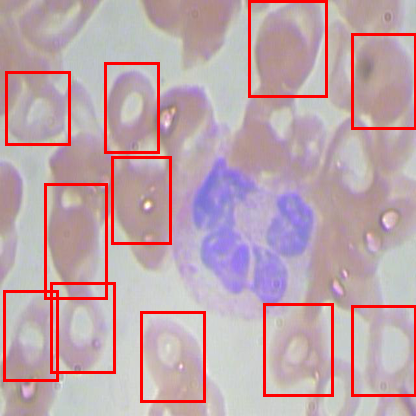

In [19]:
boundig_boxes = decode_bboxes_y_true(x_batch[0], y_batch[0])
pil_img = plot_bboxes(x_batch[0], boundig_boxes, width=3)
display(pil_img)

In [20]:
split = int(0.8*len(image_wrapper_list))
print('Train/Valid split:', split, '/', len(image_wrapper_list)-split)

Train/Valid split: 274 / 69


In [21]:
train_generator = BloodSequence(image_wrapper_list[:split],
                                target_size=416, number_cells=13, 
                                anchors=anchors, class_names=classes,
                                batch_size=16, shuffle=False,
                                preprocess_images_function=preproc_images)
valid_generator = BloodSequence(image_wrapper_list[split:],
                                target_size=416, number_cells=13, 
                                anchors=anchors, class_names=classes,
                                batch_size=16, shuffle=False,
                                preprocess_images_function=preproc_images)

# Test Model

In [22]:
from tensorflow.keras.layers import Input, Lambda, Reshape, concatenate
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Model

In [23]:
class SpaceToDepth(tf.keras.layers.Layer):
    def __init__(self, block_size, **kwargs):
        super(SpaceToDepth, self).__init__(**kwargs)
        self.block_size = block_size
    
    def call(self, x):
        return tf.space_to_depth(x, self.block_size)

In [24]:
def conv_block(X, filters, kernel_size, suffix, max_pool=False):
    X = Conv2D(filters, kernel_size, strides=(1,1), padding='same',
               use_bias=False, name='conv'+suffix)(X)
    X = BatchNormalization(name='norm'+suffix)(X)
    X = LeakyReLU(alpha=0.1)(X)
    if max_pool:
        X = MaxPooling2D(pool_size=(2, 2))(X)
    return X

In [25]:
def create_yolov2(input_size, grid_size, number_anchors, number_classes):

    assert isinstance(input_size, (tuple, list)) and len(input_size) == 2
    assert isinstance(input_size[0], int) and input_size[0] > 0
    assert isinstance(input_size[1], int) and input_size[1] > 0
    assert isinstance(grid_size, (tuple, list)) and len(grid_size) == 2
    assert isinstance(grid_size[0], int) and grid_size[0] > 0
    assert isinstance(grid_size[1], int) and grid_size[1] > 0

    input_height, input_width = input_size
    grid_height, grid_width = grid_size

    IN = Input(shape=(input_height, input_width, 3))

    X = conv_block(IN, filters=32, kernel_size=(3,3), suffix='_1', max_pool=True)
    X = conv_block(X, filters=64, kernel_size=(3,3), suffix='_2', max_pool=True)
    X = conv_block(X, filters=128, kernel_size=(3,3), suffix='_3')
    X = conv_block(X, filters=64, kernel_size=(1,1), suffix='_4')
    X = conv_block(X, filters=128, kernel_size=(3,3), suffix='_5', max_pool=True)
    X = conv_block(X, filters=256, kernel_size=(3,3), suffix='_6')
    X = conv_block(X, filters=128, kernel_size=(1,1), suffix='_7')
    X = conv_block(X, filters=256, kernel_size=(3,3), suffix='_8', max_pool=True)
    X = conv_block(X, filters=512, kernel_size=(3,3), suffix='_9')
    X = conv_block(X, filters=256, kernel_size=(1,1), suffix='_10')
    X = conv_block(X, filters=512, kernel_size=(3,3), suffix='_11')
    X = conv_block(X, filters=256, kernel_size=(1,1), suffix='_12')
    X = conv_block(X, filters=512, kernel_size=(3,3), suffix='_13')

    SK = X  # skip connection

    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = conv_block(X, filters=1024, kernel_size=(3,3), suffix='_14')
    X = conv_block(X, filters=512, kernel_size=(1,1), suffix='_15')
    X = conv_block(X, filters=1024, kernel_size=(3,3), suffix='_16')
    X = conv_block(X, filters=512, kernel_size=(1,1), suffix='_17')
    X = conv_block(X, filters=1024, kernel_size=(3,3), suffix='_18')
    X = conv_block(X, filters=1024, kernel_size=(3,3), suffix='_19')
    X = conv_block(X, filters=1024, kernel_size=(3,3), suffix='_20')

    SK = conv_block(SK, filters=64, kernel_size=(1,1), suffix='_21')
    SK = SpaceToDepth(block_size=2)(SK)
    X = concatenate([SK, X])

    X = conv_block(X, filters=1024, kernel_size=(3,3), suffix='_22')

    X = Conv2D(filters=number_anchors * (4+1+number_classes),
               kernel_size=(1,1), strides=(1,1), padding='same', name='conv_23')(X)
    
    OUT = Reshape((grid_height, grid_width, number_anchors, 4+1+number_classes))(X)

    model = Model(IN, OUT)
    return model

In [26]:
model = create_yolov2(input_size = (416, 416),  # (height, width)
                      grid_size = (13, 13),     # (height, width)
                      number_anchors = len(anchors),
                      number_classes = len(classes))

Instructions for updating:
Colocations handled automatically by placer.


In [27]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalizationV1)   (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 416, 416, 32) 0           norm_1[0][0]                     
__________________________________________________________________________________________________
max_poolin

# Load YOLOv2 Weights

In [28]:
def load_yolov2_weights(model, filepath, last_layer='leave'):
    pointer = 4
    weights = np.fromfile(filepath, dtype='float32')

    for i in range(1, 23):

        #
        #   Norm layers 1..22
        #
        norm_layer = model.get_layer('norm_' + str(i))

        size = np.prod(norm_layer.get_weights()[0].shape)

        beta = weights[pointer:pointer+size]; pointer += size;
        gamma = weights[pointer:pointer+size]; pointer += size;
        mean = weights[pointer:pointer+size]; pointer += size;
        var = weights[pointer:pointer+size]; pointer += size;

        norm_layer.set_weights([gamma, beta, mean, var])

        #
        #   Conv layers 1..22
        #
        conv_layer = model.get_layer('conv_' + str(i))

        size = np.prod(conv_layer.get_weights()[0].shape)
        kernel = weights[pointer:pointer+size]; pointer += size;
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])

    #
    #   Conv layer 23
    #
    if last_layer == 'leave':
        pass
    
    elif last_layer == 'load':
        conv_layer = model.get_layer('conv_23')

        size = np.prod(conv_layer.get_weights()[1].shape)
        bias   = weights[pointer:pointer+size]; pointer += size;

        size = np.prod(conv_layer.get_weights()[0].shape)
        kernel = weights[pointer:pointer+size]; pointer += size;
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])

        conv_layer.set_weights([kernel, bias])
        
    elif last_layer == 'rand':
        conv_layer = model.get_layer('conv_23') # the last convolutional layer
        weights = conv_layer.get_weights()
        
        output_shape = model.layers[-1].output_shape
        _, grid_w, grid_h, _, _ = output_shape
        
        new_kernel = np.random.normal(size=weights[0].shape) / (grid_w*grid_h)
        new_bias   = np.random.normal(size=weights[1].shape) / (grid_w*grid_h)

        conv_layer.set_weights([new_kernel, new_bias])
    
    else:
        raise ValueError("Parameter last_layer must be 'leave', 'load' or 'rand'.")

In [29]:
np.random.seed(0)

In [30]:
load_yolov2_weights(model, 'yolov2.weights', last_layer='rand')

In [31]:
netout = model.predict(x_batch)

In [32]:
netout.shape

(16, 13, 13, 5, 6)

In [33]:
np.round(netout[0][1][8], 2)

array([[ 0.05, -0.05, -0.09,  0.26,  0.03,  0.2 ],
       [-0.21, -0.11,  0.13,  0.04,  0.08, -0.  ],
       [-0.13, -0.03, -0.11, -0.23,  0.08, -0.05],
       [ 0.08,  0.05,  0.05, -0.03, -0.11, -0.21],
       [-0.05, -0.04, -0.03, -0.1 ,  0.15, -0.08]], dtype=float32)

In [34]:
# np.save('netout.npz', netout)

In [35]:
netout_ref = np.load('netout.npz.npy')

In [36]:
np.all(netout == netout_ref)

True

# Loss Function

In [37]:
LABELS = ['RBC']

IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3
NMS_THRESHOLD    = 0.3
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 100
TRUE_BOX_BUFFER  = 50

In [38]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [39]:
def custom_loss(y_true, y_pred):
    nb_batch = tf.shape(y_true)[0]
    mask_shape = tf.shape(y_true)[:4]  # (b, g, g, a)
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [nb_batch, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
#     seen = tf.Variable(0.)
#     total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
#     res = tf.reduce_sum(y_true)
#     res = tf.Print(res, [tf.shape(tf.sigmoid(y_pred[..., :2]))], message='DEBUG \t', summarize=1000)
#     res = tf.Print(res, [tf.shape(cell_grid)], message='DEBUG \t', summarize=1000)
#     res = tf.Print(res, [tf.shape(pred_box_xy)], message='DEBUG \t', summarize=1000)
#     return res
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    
    
    intersect_areas = tf.Print(intersect_areas, [tf.shape(intersect_areas)], message='intersect_areas', summarize=1000)
    union_areas = tf.Print(union_areas, [tf.shape(union_areas)], message='union_areas', summarize=1000)
    
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    # conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    conf_mask = conf_mask + (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
#    seen = tf.assign_add(seen, 1.)
    
    # Warmup    
#     true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
#                           lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
#                                    true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
#                                    tf.ones_like(coord_mask)],
#                           lambda: [true_box_xy, 
#                                    true_box_wh,
#                                    coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

    
    
#     y_true_shape = tf.shape(y_true)
#     y_pred_shape = tf.shape(y_pred)
#     true_boxes_shape = tf.shape(true_boxes)
    
#     loss = tf.Print(loss, [y_true_shape], message='y_true_shape', summarize=1000)
#     loss = tf.Print(loss, [y_pred_shape], message='y_pred_shape', summarize=1000)
#     loss = tf.Print(loss, [true_boxes_shape], message='true_boxes_shape', summarize=1000)
    
    """
    Debugging code
    """    
    current_recall = nb_pred_box/(nb_true_box + 1e-6)
#    total_recall = tf.assign_add(total_recall, current_recall) 

    loss = tf.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
#    loss = tf.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
    
    return loss

In [40]:
true_boxes = tf.placeholder(tf.float32, shape=(None, 1, 1, 1, 50, 4))
#y_true = tf.placeholder(tf.float32, shape=(None, 13, 13, 5, 6))
#y_pred = tf.placeholder(tf.float32, shape=(None, 13, 13, 5, 6))

In [ ]:
loss = custom_loss(y_true, y_pred)

In [ ]:
x_batch, y_batch = train_generator[17]

In [ ]:
netout = model.predict(x_batch)

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    res = sess.run(fetches=loss, feed_dict={
        #true_boxes: b_batch[...,::-1,:],
        y_true: y_batch,
        y_pred: netout
    })

In [ ]:
res

In [44]:
res

0.4391808

In [ ]:
x_batch, y_batch = train_generator[17]
print(x_batch.shape)
print(y_batch.shape)

In [41]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

In [42]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=3, 
                           mode='min', 
                           verbose=1)

checkpoint = ModelCheckpoint('weights_blood.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)

In [43]:

optimizer = tf.keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


In [44]:
model.compile(loss=custom_loss, optimizer=optimizer)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:
```python
    sess = tf.Session()
    with sess.as_default():
        tensor = tf.range(10)
        print_op = tf.print(tensor)
        with tf.control_dependencies([print_op]):
          out = tf.add(tensor, tensor)
        sess.run(out)
    ```
Additionally, to use tf.print in python 2.7, users must make sure to import
the following:

  `from __future__ import print_function`



In [45]:
hist = model.fit_generator(generator        = train_generator, 
                            steps_per_epoch  = len(train_generator), 
                            epochs           = 100, 
                            verbose          = 1,
                            validation_data  = valid_generator,
                            validation_steps = len(valid_generator),
                            # callbacks        = [early_stop, checkpoint, tensorboard], 
                            callbacks        = [early_stop, checkpoint],  # <- Marcin added this
                            max_queue_size   = 3)

Epoch 1/100
5/5 [==============================] - 1s 297ms/step - loss: 0.3597

Epoch 00001: val_loss improved from inf to 0.35969, saving model to weights_blood.h5
18/18 [==============================] - 15s 860ms/step - loss: 0.3484 - val_loss: 0.3597
Epoch 2/100
5/5 [==============================] - 1s 205ms/step - loss: 0.2256

Epoch 00002: val_loss improved from 0.35969 to 0.22556, saving model to weights_blood.h5
18/18 [==============================] - 11s 590ms/step - loss: 0.2050 - val_loss: 0.2256
Epoch 3/100
5/5 [==============================] - 1s 206ms/step - loss: 0.2035

Epoch 00003: val_loss improved from 0.22556 to 0.20354, saving model to weights_blood.h5
18/18 [==============================] - 10s 569ms/step - loss: 0.1387 - val_loss: 0.2035
Epoch 4/100
5/5 [==============================] - 1s 203ms/step - loss: 0.1652

Epoch 00004: val_loss improved from 0.20354 to 0.16518, saving model to weights_blood.h5
18/18 [==============================] - 10s 558ms/ste

# Test

In [46]:

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def _softmax(x, axis=-1, t=-100.):
    x = x - np.max(x)
    
    if np.min(x) < t:
        x = x/np.min(x)*t
        
    e_x = np.exp(x)
    
    return e_x / e_x.sum(axis, keepdims=True)

In [47]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3    

In [48]:
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])  
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

In [49]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, c = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.c     = c
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return self.score

In [50]:
def decode_netout(netout, anchors, nb_class, obj_threshold=0.3, nms_threshold=0.3):
    grid_h, grid_w, nb_box = netout.shape[:3]

    boxes = []
    
    netout = netout.copy()
    # decode the output by the network
    netout[..., 4]  = _sigmoid(netout[..., 4])
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_threshold
    
    for row in range(grid_h):
        for col in range(grid_w):
            for b in range(nb_box):
                # from 4th element onwards are confidence and class classes
                classes = netout[row,col,b,5:]
                
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout[row,col,b,:4]

                    x = (col + _sigmoid(x)) / grid_w # center position, unit: image width
                    y = (row + _sigmoid(y)) / grid_h # center position, unit: image height
                    w = anchors[2 * b + 0] * np.exp(w) / grid_w # unit: image width
                    h = anchors[2 * b + 1] * np.exp(h) / grid_h # unit: image height
                    confidence = netout[row,col,b,4]
                    
                    box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
                    
                    boxes.append(box)

    # suppress non-maximal boxes
    for c in range(nb_class):
        sorted_indices = list(reversed(np.argsort([box.classes[c] for box in boxes])))

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            
            if boxes[index_i].classes[c] == 0: 
                continue
            else:
                for j in range(i+1, len(sorted_indices)):
                    index_j = sorted_indices[j]
                    
                    if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_threshold:
                        boxes[index_j].classes[c] = 0
                        
    # remove the boxes which are less likely than a obj_threshold
    boxes = [box for box in boxes if box.get_score() > obj_threshold]
    
    return boxes    

In [51]:
# def plot_bboxes(image_np, boundig_boxes, color=(255,0,0), width=1):
#     pil_img = PIL.Image.fromarray((image_np*255).astype(np.uint8))
#     draw = PIL.ImageDraw.Draw(pil_img)
    
#     for bbox in boundig_boxes:
#         draw.rectangle(bbox, outline=color, width=width)
    
#     return pil_img

In [52]:
def draw_boxes(image, boxes, labels):
    image_h, image_w, _ = image.shape

    pil_img = PIL.Image.fromarray(image)
    draw = PIL.ImageDraw.Draw(pil_img)
        
    for box in boxes:
        xmin = int(box.xmin*image_w)
        ymin = int(box.ymin*image_h)
        xmax = int(box.xmax*image_w)
        ymax = int(box.ymax*image_h)
        
        
        print([xmin, ymin, xmax, ymax])
        draw.rectangle([xmin, ymin, xmax, ymax], outline=(0,255,0), width=3)

#         cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,255,0), 3)
#         cv2.putText(image, 
#                     labels[box.get_label()] + ' ' + str(box.get_score()), 
#                     (xmin, ymin - 13), 
#                     cv2.FONT_HERSHEY_SIMPLEX, 
#                     1e-3 * image_h, 
#                     (0,255,0), 2)
        
    return np.array(pil_img)

In [53]:
LABELS = ['RBC']

IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3
NMS_THRESHOLD    = 0.3
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 100
TRUE_BOX_BUFFER  = 50

In [54]:
# model.load_weights("weights_blood.h5")

[343, 26, 411, 122]
[4, 71, 71, 149]
[104, 63, 161, 153]
[155, 81, 214, 159]
[46, 133, 112, 215]
[41, 189, 102, 295]
[53, 284, 118, 373]
[264, 304, 331, 393]
[140, 314, 205, 400]


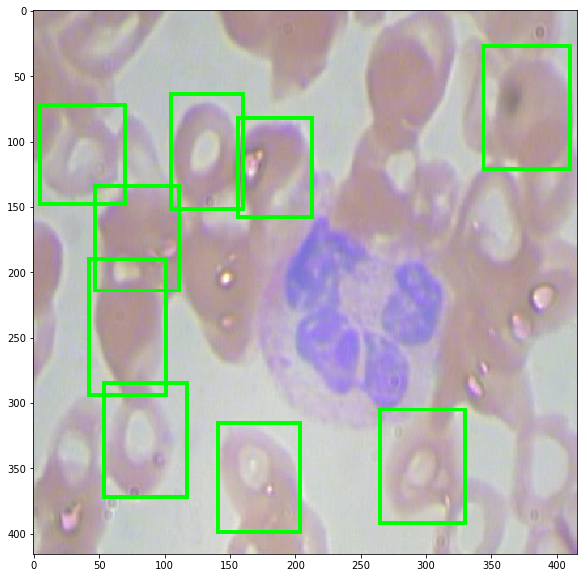

In [55]:
#image = cv2.imread('/home/marcin/Datasets/blood-cells/dataset-master/JPEGImages/BloodImage_00032.jpg')
#image = cv2.imread('/home/andy/data/coco/val2014/COCO_val2014_000000000196.jpg')
#image = cv2.imread(all_imgs[train_valid_split:][28]['filename'])

plt.figure(figsize=(10,10))

# input_image = cv2.resize(image, (416, 416))
# input_image = input_image / 255.
# input_image = input_image[:,:,::-1]
input_image = x_batch[0]
image = (input_image*255).astype(np.uint8)
input_image = np.expand_dims(input_image, 0)



netout = model.predict(input_image)

boxes = decode_netout(netout[0], 
                      obj_threshold=0.5,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image); plt.show()

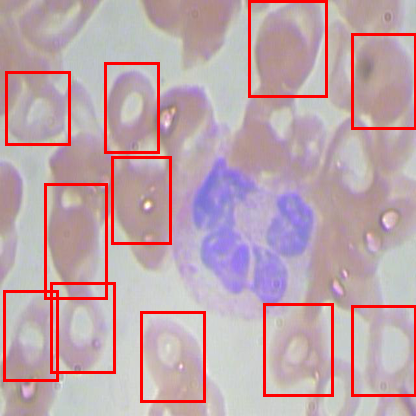

In [56]:
boundig_boxes = decode_bboxes_y_true(x_batch[0], y_batch[0])
pil_img = plot_bboxes(x_batch[0], boundig_boxes, width=3)
display(pil_img)